# Auto loans default

The project is about analysis and predition based on the data regarding auto loans defaults. The goal is to find out what are the main factors impacting if the client deafults on the auto loan or not. It consist of exploratory data analysis, feauture engineering, some visualization and model creation and tuning. 

Source of data:
https://www.kaggle.com/datasets/saurabhbagchi/dish-network-hackathon?select=Data_Dictionary.csv


In [1]:
#Importing neccessery libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,plot_confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn import svm

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150 # Option to see the entire content of the description


# Data

Since that was a contest, the data is already splitted into train and test. I will be using only train data. The "data_dictionary" is the description of columns. 


In [2]:
# Reading the data

data_dictionary = pd.read_csv('Data_Dictionary.csv')
train = pd.read_csv("Train_Dataset.csv", dtype = 'str')

During the reading of the files the warning was triggered: 

"<i>DtypeWarning: Columns (1,7,8,16,17,18,19,20,35) have mixed types.Specify dtype option on import or set low_memory=False</i>". 

Since there are columns with mixed types, I decided to treat all of the columns as a objects (strings), and then change them according to type/description of given column.

In [3]:
data_dictionary

,Variable,Description
0,ID,Client Loan application ID
1,Client_Income,Client Income in $
2,Car_Owned,Any Car owned by client before applying for the loan for another car (0 means No and 1 means otherwise)
3,Bike_Owned,Any bike owned by client (0 means No and 1 means otherwise)
4,Active_Loan,Any other active loan at the time of aplication of loan (0 means No and 1 means otherwise)
5,House_Own,Any house owned by client (0 means No and 1 means otherwise)
6,Child_Count,Number of children the client has
7,Credit_Amount,Credit amount of the loan in $
8,Loan_Annuity,Loan annuity in $
9,Accompany_Client,Who accompanied the client when client applied for the loan


There are 40 columns in total; Some of them are quite typical for credit risk analysis like income, loan amount, education, financial situation or number of issues. Additionally we also have information that potentially look irrelevant (e.g. day of the week and hour that client applied for a loan or age of ID document), but may surprisingly prove otherwise.

Last column ("Default") is to indicate the the client defaulted or not. This is going to be the target value for training and then predicting. 

### Data cleaning, feauture engineering



There is some work to be done to redefine types of some columns, remove the outliers and creating dummy values.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121856 entries, 0 to 121855
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   ID                          121856 non-null  object
 1   Client_Income               118249 non-null  object
 2   Car_Owned                   118275 non-null  object
 3   Bike_Owned                  118232 non-null  object
 4   Active_Loan                 118221 non-null  object
 5   House_Own                   118195 non-null  object
 6   Child_Count                 118218 non-null  object
 7   Credit_Amount               118224 non-null  object
 8   Loan_Annuity                117044 non-null  object
 9   Accompany_Client            120110 non-null  object
 10  Client_Income_Type          118155 non-null  object
 11  Client_Education            118211 non-null  object
 12  Client_Marital_Status       118383 non-null  object
 13  Client_Gender               1

In [5]:
# Removing ID column - no value added
train = train.drop('ID', axis = 1)

In [6]:
#Correction of column name Client City Rating
train.rename(columns = {"Cleint_City_Rating":"Client_City_Rating"}, inplace = True)

In [7]:
# % of missing values for given columns, sorted

def missing_values(dataframe):
    count = dataframe.isna().sum().sort_values(ascending=False)
    percentage = dataframe.isna().sum().sort_values(ascending=False)/len(dataframe)*100 
    missing = pd.concat([count,percentage],axis = 1)
    missing.columns = ['count', '% of total']
    
    return missing

#imputing methods: 

def impute_nan(column, value_from):
    train.loc[train[column].str.contains(value_from) == True, column] = np.nan 
    
def impute_value(columns, fill_value=0):
    if type(columns) == list:
        for col in columns:
            if fill_value == "mean":
                subset = train[col]
                train[col].fillna(subset.mean(), inplace = True)
            else:
                train[col].fillna(fill_value, inplace = True)
    else:
        if fill_value == "mean":
            subset = train[columns]
            train[columns].fillna(subset.mean(), inplace = True)
        else:
            train[columns].fillna(fill_value, inplace = True)
        

In [8]:
# remove rows where there is no the amount of the credit
train.dropna(subset=['Credit_Amount'], inplace = True)

In [9]:
missing_values(train)

,count,% of total
Own_House_Age,77697,65.720158
Score_Source_1,66831,56.529131
Social_Circle_Default,60130,50.861077
Client_Occupation,40161,33.970260
Score_Source_3,26132,22.103803
Credit_Bureau,17960,15.191501
ID_Days,5791,4.898329
Score_Source_2,5513,4.663182
Population_Region_Relative,4696,3.972121
Loan_Annuity,4667,3.947591


The are several columns where the missing values are more than 10% in the whole dataset. The approach to missing values differs depending on % of missing values and type of column. For columns with very high missing values the most effective way is to remove the whole column. For other, dropping the rows or imputing the values may be reasonable.

In [10]:
#Removing the columns with the highest number of missing values
train.drop(['Own_House_Age', 'Score_Source_1', 'Social_Circle_Default'], axis =1, inplace = True)

Additionally it makes sense to remove the entire rows for columns with lower than 2% of missing values. Such loss in data will not make the significant impact to the model. 

In [11]:
#Dropping entire rows if the missing data for feauture is less than 2% of total. 
subset_col = missing_values(train)[missing_values(train)['% of total']<2].index.tolist()
train.dropna(axis = 0, subset=subset_col, inplace = True)

For Client occupation and Client education I decided to use "Unknown" for NaN values. This is because I think there may be some valuable information coming from others types of occupation and eduction, and the number of missing values is still too high to remove entire rows. 

In [12]:
impute_value(['Client_Occupation', 'Client_Education'], 'Unknown')

Almost 40% values of Score Source_3 is missing, however I think that if the distribution is well-balances we can impute here the mean value. First, we need to change the type of column. For starters, let me replace the unwanted characters from data. The same applies to Score Source_2. 

In [13]:
impute_nan("Score_Source_3", "&")

In [14]:
#changing the data type to float
train['Score_Source_3'] = train['Score_Source_3'].astype('float')
train['Score_Source_2'] = train['Score_Source_2'].astype('float')

In [15]:
train[['Score_Source_3','Score_Source_2']].describe()

,Score_Source_3,Score_Source_2
count,83861.000000,102601.000000
mean,0.511154,0.519131
std,0.194358,0.784572
min,0.000527,0.000005
25%,0.372334,0.389463
50%,0.537070,0.564699
75%,0.667458,0.663666
max,0.896010,100.000000


Score = 100? Seems like a mistake - will change that to mean.

In [16]:
#checking the number of rows with value higher than "typical"
train[train['Score_Source_2'] > 1]

,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Client_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_2,Score_Source_3,Phone_Change,Credit_Bureau,Default
44468,15750,1,1,0,1,0,17776.8,1306.35,Partner,Commercial,Graduation,M,Female,CL,Home,0.00702,11352,653,3920,3947,1,0,0,Drivers,2,2,1,14,Yes,No,Government,100.0,0.403142,NaN,1,0
73097,11250,0,1,1,1,0,18000,900,Alone,Govt Job,Graduation,D,Male,RL,Home,0.0228,8675,445,359,1336,1,0,0,Core,1,2,3,12,Yes,Yes,School,100.0,0.047601,126,0,0
105522,15750,1,1,0,1,1,32537.7,2997,Alone,NaN,Graduation,M,Female,CL,Home,0.01885,NaN,122,5303,3006,1,0,0,Unknown,3,2,2,12,Yes,Yes,Business Entity Type 3,100.0,0.535276,41,0,0
109378,22500,0,0,1,NaN,0,83560.5,2456.1,Relative,Retired,Secondary,M,Male,CL,Home,0.018634,21439,365243,1315,4536,1,0,0,Unknown,2,2,5,13,Yes,Yes,XNA,100.0,0.164414,1875,5,1
114099,27000,0,0,0,NaN,0,107820,3165.3,Alone,Service,Graduation,M,Female,CL,Home,0.010006,16144,2318,106,4215,1,0,0,High skill tech,2,1,5,16,Yes,Yes,Industry: type 9,100.0,0.683269,0,1,0
119243,20700,1,0,1,1,0,4797,480.15,Relative,Service,Secondary,M,Male,CL,Home,0.015221,14007,3086,6709,4407,1,1,1,Sales,2,2,2,12,Yes,Yes,Trade: type 7,100.0,0.833787,1341,2,0


In [17]:
#subset of correct data - basis for mean
score_2 = train[train.loc[:, 'Score_Source_2'] <= 1]['Score_Source_2']
#changing the outliers to mean value
train.loc[train['Score_Source_2'] == 100, "Score_Source_2"] = score_2.mean() 

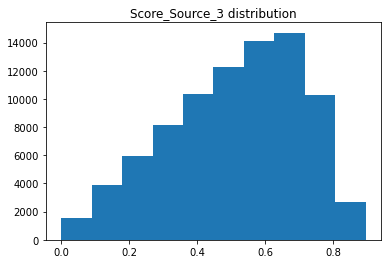

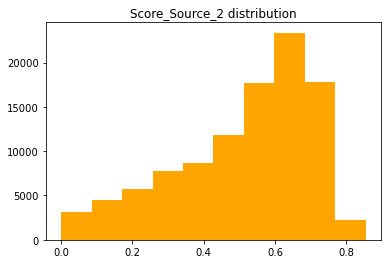

In [18]:
#distributions of Score_Sources
plt.hist(train['Score_Source_3'])
plt.title("Score_Source_3 distribution")
plt.show()
plt.hist(train['Score_Source_2'], color ='orange')
plt.title("Score_Source_2 distribution")
plt.show()

Means and medians (50% percentile) are quite close to each other,  meaning that the distribution is quite well-balanced, also confirmed by histograms - using mean value to impute should be reasonable approach. 

In [19]:
impute_value(['Score_Source_3', 'Score_Source_2'],fill_value="mean")

In [20]:
missing_values(train)

,count,% of total
Credit_Bureau,16346,15.191732
ID_Days,5263,4.891355
Population_Region_Relative,4295,3.991710
Loan_Annuity,4274,3.972193
Client_Income_Type,3259,3.028867
Employed_Days,3243,3.013997
Child_Count,3233,3.004703
Client_Housing_Type,3232,3.003773
Loan_Contract_Type,3224,2.996338
Type_Organization,3222,2.994479


For Credit Bureau (total number of inquires). If we don't have any indication it is safe to assume client did not inquire for credit last year. 

In [21]:
#chaning to float and imputing 0 for NaNs
train['Credit_Bureau'] = train['Credit_Bureau'].astype('float')
impute_value('Credit_Bureau')

For columns with "Type" in name, I will impute "Other" for NaN. 

In [22]:
#selecting "Type" columns
type_columns = train.columns[train.columns.str.contains("Type")].tolist()

for col in type_columns:
    train.loc[:,col].fillna('Other', inplace = True) 

In [23]:
#check if imputing was correct
train.loc[:,type_columns].isna().sum()

Client_Income_Type     0
Loan_Contract_Type     0
Client_Housing_Type    0
Type_Organization      0
dtype: int64

"Population Region Relative" is another columns that are eligable to impute mean values for NaN. First, some unwanted characters needs to be removed.

In [24]:
impute_nan('Population_Region_Relative', '@')
impute_nan('Population_Region_Relative', '#')

In [25]:
#changing the data type to float
train["Population_Region_Relative"] = train["Population_Region_Relative"].astype('float')
train["Population_Region_Relative"].describe()

count    103293.000000
mean          0.020868
std           0.013896
min           0.000533
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: Population_Region_Relative, dtype: float64

In [26]:
impute_value("Population_Region_Relative", fill_value="mean")

In [27]:
missing_values(train)

,count,% of total
ID_Days,5263,4.891355
Loan_Annuity,4274,3.972193
Employed_Days,3243,3.013997
Child_Count,3233,3.004703
Application_Process_Hour,3218,2.990762
House_Own,3212,2.985186
Bike_Owned,3207,2.980539
Active_Loan,3203,2.976821
Age_Days,3199,2.973104
Phone_Change,3197,2.971245


For columns like: "Child Count", "Bike Owned", "Active_Loan" and "Car Owned", considering the relative low % missing values (around 3%), and type of the columns it is safe to assume that if the data is not there, it means the answer is no (imputing 0). 

In [28]:
train['Child_Count']= train['Child_Count'].astype('float')
train['House_Own']= train['House_Own'].astype('float')
train['Bike_Owned']= train['Bike_Owned'].astype('float')
train['Active_Loan']= train['Active_Loan'].astype('float')
train['Car_Owned']= train['Car_Owned'].astype('float')



impute_value(["Child_Count", "House_Own", "Bike_Owned", "Active_Loan", "Car_Owned"], 0)

Imputing "Application_Process_Hour": based on the other data, reasonable time(hour) for processing application is 10 am. Also, I do not expect this value significantly affects the results. 

In [29]:
impute_value("Application_Process_Hour", 10)

In [30]:
# removing unwanted rows for $ and # columns

train = train.drop(train[train["Loan_Annuity"] == '$'].index)
train = train.drop(train[train['Loan_Annuity'].str.contains('#')==True].index)
train = train.drop(train[train["Client_Income"] == '$'].index)
train = train.drop(train[train["Credit_Amount"] == '$'].index)

#changing the data to floats
train['Client_Income']= train['Client_Income'].astype('float')
train['Loan_Annuity']= train['Loan_Annuity'].astype('float')
train['Credit_Amount']= train['Credit_Amount'].astype('float')
train['Phone_Change']= train['Phone_Change'].astype('float')
train['Default'] = train['Default'].astype('int')


In [31]:
train['Registration_Days']

0         6123
1         7833
2          NaN
3          NaN
4         5516
          ... 
121851    2661
121852     902
121853    3980
121854     895
121855    8679
Name: Registration_Days, Length: 107569, dtype: object

In [32]:
impute_nan("Age_Days", "x")
impute_nan("Employed_Days", "x")
impute_nan("ID_Days", "x")
impute_nan("Registration_Days", "x")

train['Age_Days']= train['Age_Days'].astype('float')
train['Employed_Days']= train['Employed_Days'].astype('float')
train['ID_Days']= train['ID_Days'].astype('float')
train['Registration_Days']= train['Registration_Days'].astype('float')

impute_value(["Client_Income", "Phone_Change","Loan_Annuity","Registration_Days", "Age_Days","Employed_Days", "ID_Days"], 
             "mean")

For "Maritial Status" it is safe to assume that no info = single

In [33]:
impute_value("Client_Marital_Status", 'S')

There are also additional unwanted data - categorical data to be checked: 

In [34]:
list_of_vals = {}

for col in  train.columns:
    if train[col].dtype == 'object':
        train.value_counts(col)
        list_of_vals[col] = train.value_counts(col)
        display(list_of_vals[col])
        


Accompany_Client
Alone       87210
Relative    14154
Partner      4026
Kids         1175
Others        902
Group          91
##             11
dtype: int64

Client_Income_Type
Service            53932
Commercial         24472
Retired            18616
Govt Job            7275
Other               3259
Unemployed             6
Student                6
Maternity leave        2
Businessman            1
dtype: int64

Client_Education
Secondary             74198
Graduation            25318
Graduation dropout     3497
Unknown                3223
Junior secondary       1272
Post Grad                61
dtype: int64

Client_Marital_Status
M    77054
S    18420
D     6716
W     5379
dtype: int64

Client_Gender
Male      70700
Female    36866
XNA           3
dtype: int64

Loan_Contract_Type
CL       94576
RL        9770
Other     3223
dtype: int64

Client_Housing_Type
Home         92638
Family        5076
Municipal     3740
Other         3231
Rental        1604
Office         887
Shared         393
dtype: int64

Mobile_Tag
1    107568
0         1
dtype: int64

Homephone_Tag
0    86018
1    21551
dtype: int64

Workphone_Working
0    77405
1    30164
dtype: int64

Client_Occupation
Unknown               36617
Laborers              18560
Sales                 10730
Core                   9284
Managers               7192
Drivers                6304
High skill tech        3807
Accountants            3295
Medicine               2794
Security               2397
Cooking                1985
Cleaning               1516
Private service         887
Low-skill Laborers      696
Secretaries             480
Waiters/barmen          427
Realty agents           251
HR                      177
IT                      170
dtype: int64

Client_Family_Members
2     55476
1     23622
3     18433
4      8615
5      1230
6       139
7        30
8        10
9         4
10        3
16        2
12        2
15        1
14        1
13        1
dtype: int64

Client_City_Rating
2    80188
3    15297
1    12084
dtype: int64

Application_Process_Day
2    18850
3    18070
1    17789
4    17707
5    17699
6    11792
0     5662
dtype: int64

Application_Process_Hour
10    12786
11    12727
12    11513
13    10369
14     9458
9      9303
15     8478
16     6822
17     5142
8      5095
10     3218
7      3071
18     3067
6      1978
19     1283
5      1257
4       769
20      436
3       436
21      145
2        99
22       61
1        23
0        21
23       12
dtype: int64

Client_Permanent_Match_Tag
Yes    99277
No      8292
dtype: int64

Client_Contact_Work_Tag
Yes    88217
No     19352
dtype: int64

Type_Organization
Business Entity Type 3    23152
XNA                       18629
Self-employed             13030
Other                      8733
Medicine                   3817
Business Entity Type 2     3630
Government                 3508
School                     2963
Trade: type 7              2617
Kindergarten               2370
Construction               2303
Business Entity Type 1     2057
Transport: type 4          1838
Trade: type 3              1193
Industry: type 9           1129
Security                   1117
Industry: type 3           1084
Housing                    1039
Military                    927
Agriculture                 899
Industry: type 11           877
Bank                        877
Police                      824
Postal                      766
Transport: type 2           715
Security Ministries         658
Trade: type 2               629
Restaurant                  627
University                  500
Services                    499
Transport: type 3     

The exercise above showed that several columns (Accompany_Client, Client_Gender, Type_Organization) have still some inconsistent/unwanted values. 

In [35]:
#Droping 'XNA' gender. It is only three records
train = train.drop(train[train["Client_Gender"] == 'XNA'].index)
train['Client_Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [36]:
# Replacing unwanted characters to "Other" categories

impute_nan('Accompany_Client', '##')
impute_value('Accompany_Client', 'Others')

impute_nan('Type_Organization',"XNA")
impute_value('Type_Organization', 'Other')

The data may be considered cleaned

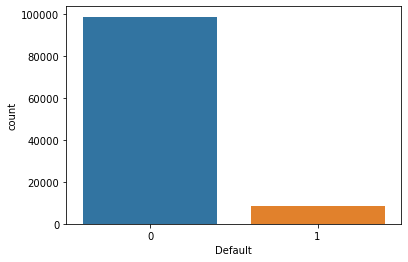

In [37]:
sns.countplot(data = train, x= 'Default')
plt.show()

There is a huge imbalance between the default and non-default results. This needs to be taken into account when measuring the performance of the model. Accuracy will not be reliable - F1 score is preffered.  

In terms of gender there is clear imbalance as well; however the relative proportion of the defaulted loans is higher for females. 

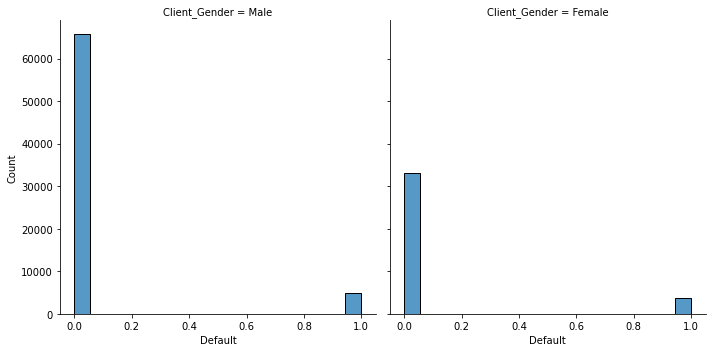

In [38]:
sns.displot(train, x="Default", col="Client_Gender")
plt.show()

The most extreme values of Credit Amount can be founding withing married and singles. For married it is probably the effect of need for bigger thus more expensive car (for family). 

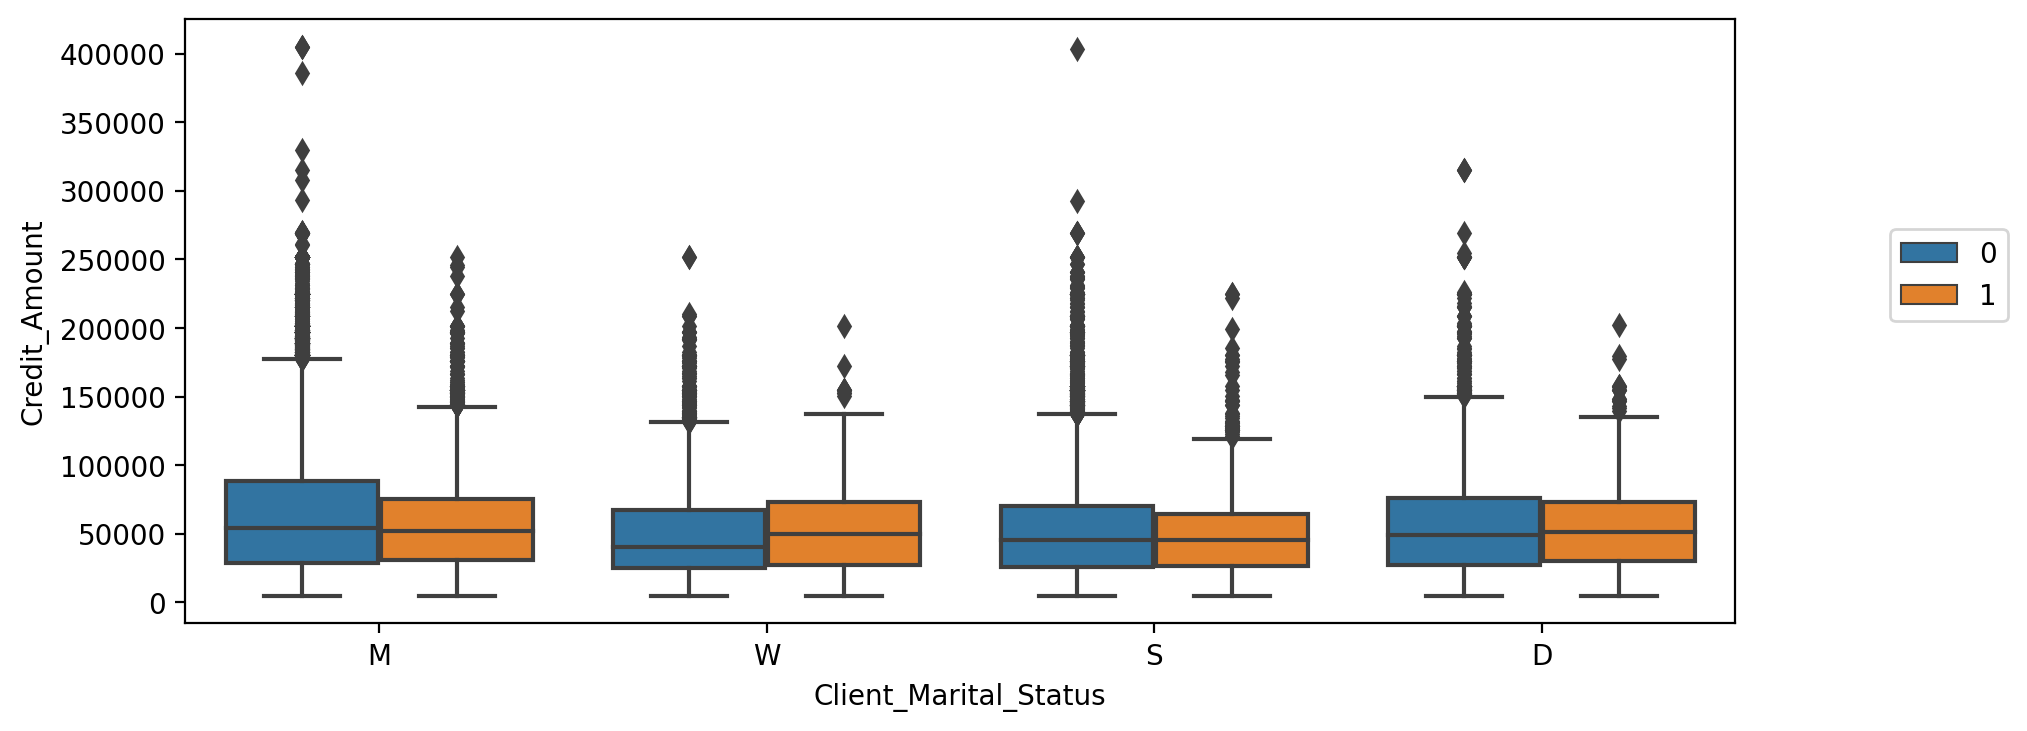

In [39]:
plt.figure(figsize=(10,4),dpi=200)
sns.boxplot(data=train,y='Credit_Amount',x='Client_Marital_Status',hue='Default')
plt.legend(loc=(1.1,0.5))

The correlation numbers between the Default and other feautures show that the external scores have the highest negative correlation with default - let's explore it further. 

In [40]:
pd.get_dummies(train).corr()['Default'].sort_values().iloc[1:-1]

Score_Source_2                  -0.151307
Age_Days                        -0.072644
Client_Education_Graduation     -0.061367
Phone_Change                    -0.054103
Client_Gender_Male              -0.051706
                                   ...   
Client_Permanent_Match_Tag_No    0.043075
Client_Income_Type_Service       0.051688
Client_Gender_Female             0.051706
Client_City_Rating_3             0.053214
Client_Education_Secondary       0.055429
Name: Default, Length: 189, dtype: float64

I divided the values for both scores into cohorts to group the results.

In [41]:
def cohort(score):
    if score < 0.3:
        return '0.3 and lower'
    elif score < 0.6:
        return '0.3 - 0.6'
    else:
        return "over 0.6"

In [42]:
train['Score_2 Cohort'] = train['Score_Source_2'].apply(cohort)
train['Score_3 Cohort'] = train['Score_Source_3'].apply(cohort)

In [43]:
train.head(10)[['Score_Source_2','Score_2 Cohort']]

,Score_Source_2,Score_2 Cohort
0,0.478787,0.3 - 0.6
1,0.215068,0.3 and lower
2,0.552795,0.3 - 0.6
3,0.135182,0.3 and lower
4,0.301182,0.3 - 0.6
5,0.697928,over 0.6
6,0.602545,over 0.6
7,0.657508,over 0.6
8,0.637594,over 0.6
10,0.770343,over 0.6


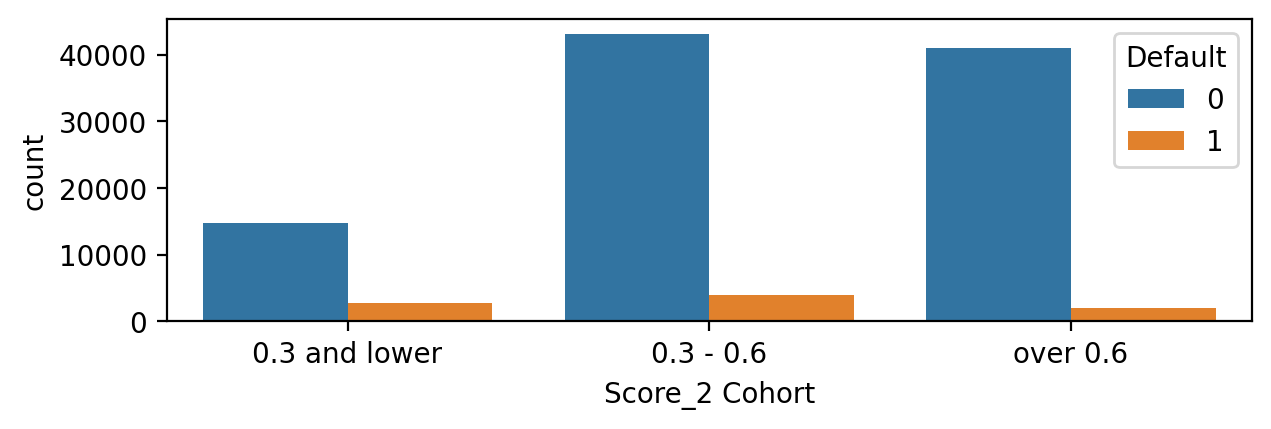

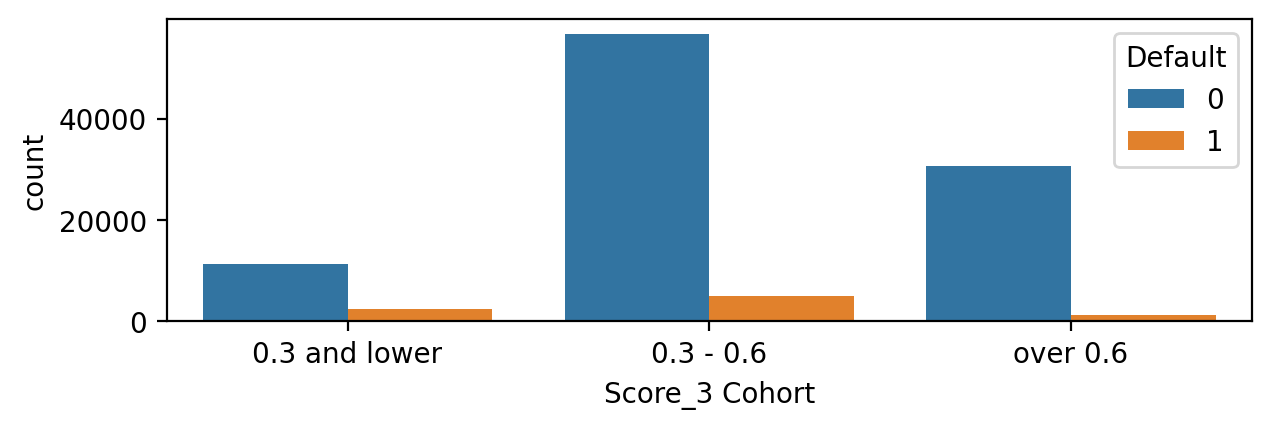

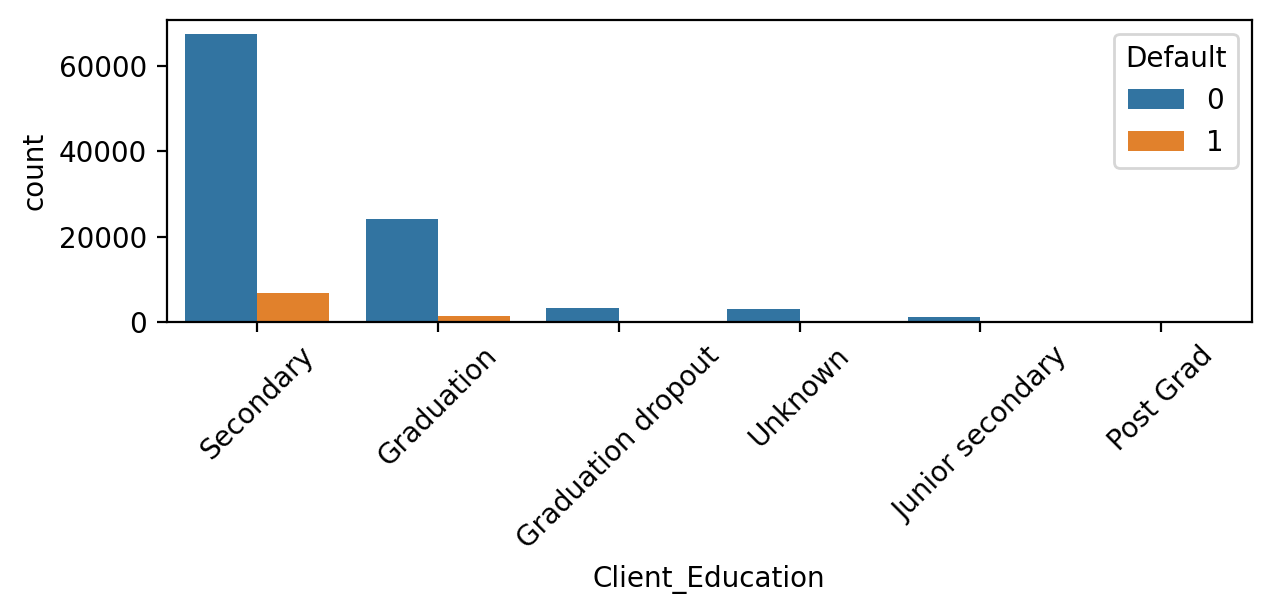

In [44]:
plt.figure(figsize=(7,2),dpi=200)
sns.countplot(data=train,x='Score_2 Cohort', hue = 'Default', order = ['0.3 and lower', '0.3 - 0.6', 'over 0.6'])
plt.show()
plt.figure(figsize=(7,2),dpi=200)
sns.countplot(data=train,x='Score_3 Cohort', hue = 'Default', order = ['0.3 and lower', '0.3 - 0.6', 'over 0.6'])
plt.show()
plt.figure(figsize=(7,2),dpi=200)
sns.countplot(data=train,x='Client_Education', hue = 'Default')
plt.xticks(rotation = 45)
plt.show()

There is no clear patterns regarding the cohorts that have been created other than the frequency of the event (default or no default) follows the number of actual records. 

## 3. Model Prediction

Decision Tree, Random Forest and AdaBoost have been used to build the relevant model for prediction. As pointed below, none of the above showed the satisfactory prediction power (f1 score below 0.5) meaning that naive model of random choosing if the loan is defaulted would perform better. 

In [45]:
# creating the X and y(target) variables 

X = train.drop(['Default'],axis=1)
X = pd.get_dummies(X,drop_first=True)

y = train['Default']

In [46]:
#splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [47]:
dt = DecisionTreeClassifier(max_depth=12)

In [48]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=12)

In [49]:
preds = dt.predict(X_test)

In [50]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9944
           1       0.25      0.05      0.08       813

    accuracy                           0.92     10757
   macro avg       0.59      0.52      0.52     10757
weighted avg       0.88      0.92      0.89     10757



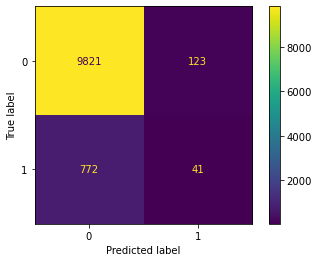

In [51]:
plot_confusion_matrix(dt,X_test,y_test)

In [52]:
imp_feats_dt = pd.DataFrame(data=dt.feature_importances_,index=X.columns,columns=['Feature Importance']).sort_values("Feature Importance")
imp_feats_dt.sort_values('Feature Importance', ascending=False)

,Feature Importance
Score_Source_2,0.175904
Score_Source_3,0.170852
Employed_Days,0.056396
Age_Days,0.051833
ID_Days,0.042801
...,...
Client_Income_Type_Unemployed,0.000000
Application_Process_Hour_3,0.000000
Application_Process_Hour_23,0.000000
Application_Process_Hour_22,0.000000


The highest importance has been attached to the Scores and  Employed and Age Days.

In [54]:
rf = RandomForestClassifier(n_estimators=300)

rf.fit(X_train,y_train)

preds = rf.predict(X_test)

print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      9944
           1       1.00      0.11      0.21       813

    accuracy                           0.93     10757
   macro avg       0.97      0.56      0.59     10757
weighted avg       0.94      0.93      0.91     10757



In [66]:
imp_feats_rf = pd.DataFrame(data=rf.feature_importances_,index=X.columns,columns=['Feature Importance']).sort_values("Feature Importance")
imp_feats_rf.sort_values('Feature Importance', ascending=False)

,Feature Importance
Score_Source_2,6.255181e-02
Score_Source_3,5.537991e-02
ID_Days,5.044950e-02
Age_Days,5.008915e-02
Registration_Days,5.002100e-02
...,...
Client_Family_Members_15,3.056891e-07
Client_Family_Members_12,0.000000e+00
Mobile_Tag_1,0.000000e+00
Client_Family_Members_14,0.000000e+00


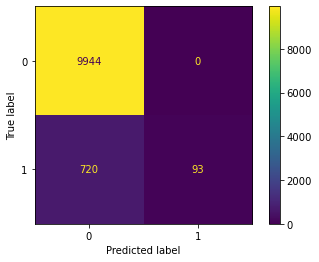

In [55]:
plot_confusion_matrix(rf,X_test,y_test)

In [56]:
ada_model = AdaBoostClassifier()

In [57]:
ada_model.fit(X_train,y_train)

preds = ada_model.predict(X_test)

In [67]:
imp_feats_ada = pd.DataFrame(data=ada_model.feature_importances_,index=X.columns,columns=['Feature Importance']).sort_values("Feature Importance")
imp_feats_ada.sort_values('Feature Importance', ascending=False)

,Feature Importance
Score_Source_3,0.16
Score_Source_2,0.14
Age_Days,0.08
Credit_Amount,0.06
Client_Gender_Male,0.04
...,...
Type_Organization_Security,0.00
Type_Organization_School,0.00
Type_Organization_Restaurant,0.00
Type_Organization_Religion,0.00


In [58]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      9944
           1       0.57      0.03      0.05       813

    accuracy                           0.92     10757
   macro avg       0.75      0.51      0.51     10757
weighted avg       0.90      0.92      0.89     10757



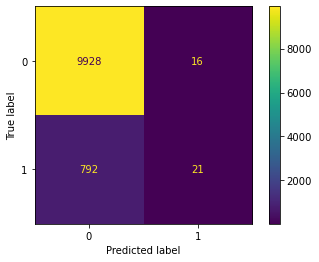

In [59]:
plot_confusion_matrix(ada_model,X_test,y_test)